<a href="https://colab.research.google.com/github/Avi-000-Avi/Word-Representation/blob/master/Learning_word_Vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To implement a fully functional word embedding model:

Loading all the dependencies

Preparing the text corpus

Defining the model

Training the model

Analyzing the model

Plotting the word cluster using the t-Distributed Stochastic Neighbor Embedding (t-SNE) algorithm

Plotting the model on TensorBoard





Gensim module to train our word2vec model. Gensim provides large-scale multi-core processing support to many popular algorithms, including Latent Dirichlet Allocation (LDA), Hierarchical Dirichlet Process (HDP), and word2vec.

In [0]:
!pip3 install --upgrade gensim


In [0]:
import multiprocessing
import os
import requests
import re
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.contrib.tensorboard.plugins import projector

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.plugins import projector

In [0]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
def sentence_to_wordlist(raw):
  clean = re.sub("[^a-zA-Z]"," ",raw)
  words = clean.split()
  return list(map(lambda x:x.lower(), words))

In [0]:
#Download text the gutenberg website
filepath = 'http://www.gutenberg.org/files/33224/33224-0.txt'
corpus_raw = requests.get(filepath).text


In [0]:
#Clean text
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
raw_sentences = tokenizer.tokenize(corpus_raw)
raw_sentences

In [0]:
#Sentence where each word is tokenized
sentences = (sentence_to_wordlist(raw) for raw in raw_sentences if raw)
sentences = list(sentences)
sentences

In [0]:
token_count = sum([len(sentence) for sentence in sentences])
print(f'The book corpus conntains {token_count} tokens.')

The book corpus conntains 425633 tokens.


Now let's use gensim in our definition of the word2vec model. To begin, let's define a few hyperparameters for our model, such as the dimension, which means how many low-level features we want to learn. Each dimension will learn a unique concept of gender, objects, age, and so on.

Computational linguistics model tip #1: Increasing the number of dimensions leads to better generalization... but it also adds more computational complexity. The right number is an empirical question for you to determine as an applied AI deep learning engineer!

Computational linguistics model tip #2: Pay attention to context_size. This is important because it sets the upper limit for the distance between the current and target word prediction within a sentence. This helps the model in learning the deeper relationships between a word and the other nearby words.

In [0]:
num_features = 300
min_word_count = 3

#Number of threads to run in parallel
num_workers = multiprocessing.cpu_count()

#context window length
context_size = 7

#Downsample setting for frequent words. 
downsampling = 1e-3

#seed for the RNG, to make the results reproducible
seed = 1
model2vec = w2v.Word2Vec(
    sg =1, seed = seed, workers = num_workers, size = num_features,
    min_count = min_word_count, window = context_size, sample = downsampling
)

model2vec.build_vocab(list(sentences))

In [0]:
#start training this might take a minute or two
model2vec.train(
    sentences, total_examples = model2vec.corpus_count, epochs =10
)

#Save to file, can be useful later
if not os.path.exists(os.path.join('trained','sample')):
  os.makedirs(os.path.join('trained','sample'))

model2vec.save(os.path.join('trained','sample','sample.w2v'))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Analyzing the model
Now that we have trained our word2vec model, let's explore what our model was able to learn. We will use most_similar() to explore the relations between various words. In the following example, you see that the model was able to learn that the word earth is related to crust, globe, and other words. It is interesting to see that we only provided the raw data and the model was able to learn all of these relations and concepts automatically!

In [0]:
for s in model2vec.wv.most_similar("earth"):
  print(s)

('crust', 0.7052878141403198)
('globe', 0.6609046459197998)
('inequalities', 0.6289448738098145)
('laboring', 0.6106284856796265)
('orbit', 0.610345184803009)
('planet', 0.6090341806411743)
('reduce', 0.5961793065071106)
('sun', 0.5930631160736084)
('primitive', 0.5727167129516602)
('moon', 0.5662232041358948)


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Remember that these similarities are based on the corpus of text that we used for training, and they should be thought of in that context. Generalization, and its unwanted sidekick, bias, can come into play when similarities from outdated or dissimilar training corpora are used to train a model that is applied to a new set of language data or cultural norms.

Now, let's try to derive an analogy by using two positive vectors, earth and moon, and a negative vector, orbit - do your results makes sense? Is there is a semantic relation?

for s in model2vec.wv.

In [0]:
#Find the top-N most similar words, using the multiplicative combination
for s in model2vec.wv.most_similar_cosmul(
    positive = ['earth','moon'],
    negative = ['orbit']
    ):
  print(s)

('sun', 0.8112301230430603)
('employed', 0.8007113933563232)
('crust', 0.7985720634460449)
('heaven', 0.7917311787605286)
('god', 0.7879908084869385)
('remodelled', 0.7873138785362244)
('globe', 0.7858370542526245)
('laboring', 0.7857433557510376)
('hutton', 0.7852392792701721)
('autobiography', 0.7823439240455627)


#Plotting Word Clusters Using the t-SNE algorithm

In [0]:
#Reduce dimensionality using t-SNE
tsne = sklearn.manifold.TSNE(n_components =2, random_state =0)
all_words_vectors_matrix = model2vec.wv.vectors
all_words_vectors_matrix_2d = tsne.fit_transform(all_words_vectors_matrix)


In [0]:
all_words_vectors_matrix

array([[ 0.03987976, -0.23193261,  0.01129596, ...,  0.14401263,
         0.047087  , -0.05603377],
       [ 0.05129886, -0.07213397, -0.07229324, ...,  0.12959538,
        -0.08213115,  0.02181673],
       [-0.05333057,  0.03562044, -0.05836807, ..., -0.04451198,
         0.09814543, -0.16608569],
       ...,
       [ 0.06775088,  0.02125669, -0.0451971 , ...,  0.1064846 ,
         0.14914832,  0.06774703],
       [ 0.10070186,  0.01347698, -0.07946429, ...,  0.08308388,
         0.15390864,  0.0462602 ],
       [ 0.05537172,  0.03453544,  0.00708653, ...,  0.0986234 ,
         0.08579554,  0.00447787]], dtype=float32)

In [0]:
# Create DataFrame to store words and coordinates
points = pd.DataFrame(
    [(word, coords[0], coords[1]) for word, coords in
        [(word, all_words_vectors_matrix_2d[model2vec.wv.vocab[word].index])
            for word in model2vec.wv.vocab]
     ],
    columns=["word", "x", "y"]
)
 

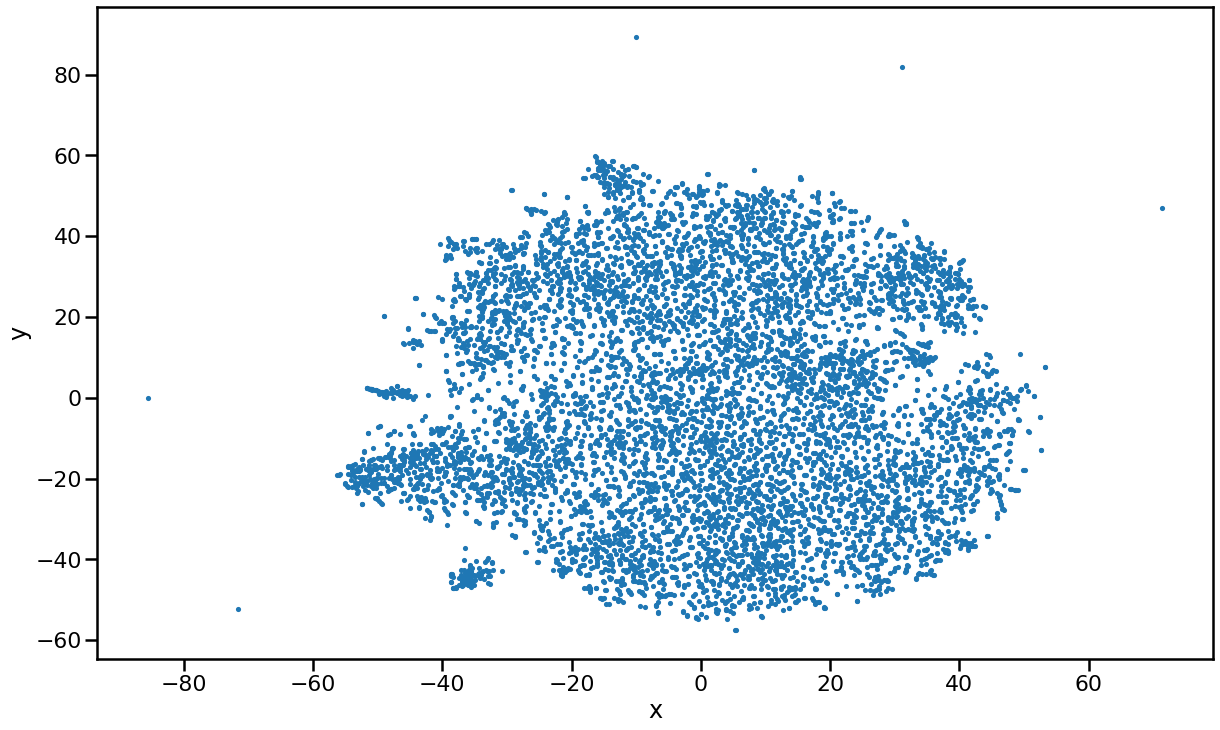

In [0]:
# Plot
sns.set_context("poster")
ax = points.plot.scatter("x", "y", s=10, figsize=(20, 12))
fig = ax.get_figure()
plt.show()

In [0]:
points.head(10)

,word,x,y
0,the,-11.060428,7.119220
1,project,-38.323952,-47.131111
2,gutenberg,-38.294300,-47.121864
3,ebook,-38.328369,-44.331139
4,of,-8.014484,-1.843695
5,principles,-39.078411,-28.794781
6,geology,-41.833134,-30.247923
7,by,-2.418578,22.384102
8,charles,-50.424011,-21.483696
9,lyell,-54.147839,-19.027416
